# Data Wrangling Project -
**Data wrangling of the tweet archive of Twitter user @dog_rates, also known as WeRateDogs**

Author: Yu Ling Wu, version: 26 February 2021

## Gather

In [3]:
import pandas as pd
import numpy as np
import wptools
import os
import requests
from PIL import Image
from io import BytesIO

In [4]:
#Load the WeRateDogs twitter archive, which was given as a csv file
df_WeRateDogs= pd.read_csv('twitter-archive-enhanced.csv')
df_WeRateDogs.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [5]:
# programmatically download and store the image prediction data
url= 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

In [6]:
with open(url.split('/')[-1], mode='wb') as file:
    file.write(response.content)

In [7]:
# check the file has downloaded
os.listdir()

['twitter-archive-enhanced.csv',
 'twitter_archive_master.csv',
 'image_predictions_clean.csv',
 'wrangle_report.pdf',
 'act_report.pdf',
 'tweet-json.txt',
 'image-predictions.tsv',
 '.ipynb_checkpoints',
 'wrangle_act.ipynb']

In [8]:
# load the file as a dataframe
image_predictions= pd.read_csv('image-predictions.tsv', sep='\t')
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [9]:
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

In [ ]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_WeRateDogs.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

In [8]:
#open the JSON file with data from Twitter's API
tweets_json = []
for line in open('data/tweet-json.txt','r'):
    tweets_json.append(json.loads(line))

In [9]:
#convert the json file into a Pandas DataFrame
tweets= pd.DataFrame(tweets_json)

## Assess

### Visual assessment

In [10]:
df_WeRateDogs

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [11]:
image_predictions.head(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [12]:
tweets.head()

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
0,None,None,Tue Aug 01 16:23:56 +0000 2017,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",39467,False,This is Phineas. He's a mystical boy. Only eve...,None,...,False,NaN,NaN,NaN,8853,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,None,None,Tue Aug 01 00:17:27 +0000 2017,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33819,False,This is Tilly. She's just checking pup on you....,None,...,False,NaN,NaN,NaN,6514,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,None,None,Mon Jul 31 00:18:03 +0000 2017,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",25461,False,This is Archie. He is a rare Norwegian Pouncin...,None,...,False,NaN,NaN,NaN,4328,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,None,None,Sun Jul 30 15:58:51 +0000 2017,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",42908,False,This is Darla. She commenced a snooze mid meal...,None,...,False,NaN,NaN,NaN,8964,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,None,None,Sat Jul 29 16:00:24 +0000 2017,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",41048,False,This is Franklin. He would like you to stop ca...,None,...,False,NaN,NaN,NaN,9774,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [13]:
#print tweets columns since there are too many to be viewed with .head()
tweets.columns

Index(['contributors', 'coordinates', 'created_at', 'display_text_range',
       'entities', 'extended_entities', 'favorite_count', 'favorited',
       'full_text', 'geo', 'id', 'id_str', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status',
       'lang', 'place', 'possibly_sensitive', 'possibly_sensitive_appealable',
       'quoted_status', 'quoted_status_id', 'quoted_status_id_str',
       'retweet_count', 'retweeted', 'retweeted_status', 'source', 'truncated',
       'user'],
      dtype='object')

#### Observations from the visual assessment: <br>
`df_WeRateDogs`:
- Some names are odd: 'such', 'quite', 'a', 'an', 'the. And some names are 'None'.
- Contains at least one retweet, i.e. not an original tweet, in row 19 where the *retweeted_status_timestamp* is not-NaN
- untidy data: columns *doggo*, *floofer*, *pupper*, *puppo* should be a single column with the dogstage in it.

`image_predictions`:
- consistency: *p1*, *p1_conf*, *p1_dog* and corresponding *p2* and *p3* column names are unclear; *p1_dogtype*, *p1_confidence*, *p1_correct* would be clearer.

`tweets`:
- untidy data: `tweets` contains missing columns that should have been added to `df_WeRateDogs`. The missing columns are *retweet_count*, *favorite_count*. The key to merge these is *tweet_id* with *id*.

### Programmatic assessment

In [14]:
#info() to check data types and see if there are missing values
df_WeRateDogs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [15]:
#look at the values of retweeted_status_id to get a feel for the data type
df_WeRateDogs.retweeted_status_id.unique()

array([             nan,   8.87473957e+17,   8.86053734e+17,
         8.30583321e+17,   8.78057613e+17,   8.78281511e+17,
         6.69000397e+17,   8.76850772e+17,   8.66334965e+17,
         8.68880398e+17,   8.73213776e+17,   8.72657584e+17,
         8.41077006e+17,   8.59196979e+17,   8.68552279e+17,
         8.65013420e+17,   8.66450706e+17,   8.37820168e+17,
         8.63062472e+17,   8.06629075e+17,   8.60563773e+17,
         8.60914485e+17,   7.61672994e+17,   8.39549326e+17,
         8.57061112e+17,   8.44704788e+17,   8.56330159e+17,
         8.42163533e+17,   8.55122533e+17,   8.31650052e+17,
         8.29374342e+17,   8.48289382e+17,   8.33124695e+17,
         8.32369877e+17,   8.47971000e+17,   7.56288534e+17,
         7.73308824e+17,   8.07106841e+17,   8.17423860e+17,
         8.40632337e+17,   6.67152164e+17,   8.39289919e+17,
         8.38905981e+17,   7.83839966e+17,   8.20749717e+17,
         8.37011345e+17,   8.36648149e+17,   8.17827839e+17,
         7.86963064e+17,

In [16]:
#look at the values of retweeted_status_user_id to get a feel for the data type
df_WeRateDogs.retweeted_status_user_id.unique()

array([             nan,   4.19698384e+09,   1.96074000e+07,
         5.12804507e+08,   1.54767397e+08,   7.87461778e+17,
         3.63890752e+08,   5.87097230e+07,   6.66990130e+07,
         7.47554344e+17,   3.41021133e+08,   5.97064155e+08,
         4.11984180e+07,   8.11740824e+08,   7.26634734e+08,
         7.12457247e+17,   4.46675020e+07,   4.87197737e+08,
         2.48855660e+07,   7.99237010e+07,   1.22832566e+09,
         1.73272909e+09,   1.95036846e+08,   2.80479778e+08,
         7.83214000e+05,   4.29683174e+09])

In [17]:
#look at the values for doggo, floofer, pupper, puppo to see how these columns work
#or what is meant by them
df_WeRateDogs.doggo.unique(), df_WeRateDogs.floofer.unique(), df_WeRateDogs.pupper.unique(), df_WeRateDogs.puppo.unique()

(array(['None', 'doggo'], dtype=object),
 array(['None', 'floofer'], dtype=object),
 array(['None', 'pupper'], dtype=object),
 array(['None', 'puppo'], dtype=object))

In [18]:
#check how many entries had doggo as the dog stage
len(df_WeRateDogs[df_WeRateDogs.doggo=='doggo'])

97

In [19]:
#check how many entries had floofer as the dog stage
len(df_WeRateDogs[df_WeRateDogs.floofer=='floofer'])

10

In [20]:
#check how many entries had pupper as the dog stage
len(df_WeRateDogs[df_WeRateDogs.pupper=='pupper'])

257

In [21]:
#check how many entries had puppo as the dog stage
len(df_WeRateDogs[df_WeRateDogs.puppo=='puppo'])

30

In [22]:
#Sum the number of dogstages per row that are not equal to None. 
#Should be 1 for each row. 0= no dog stage, >1 : multiple dog stages
dogstages=(df_WeRateDogs[['doggo','floofer', 'pupper','puppo']]!='None').sum(axis=1)

In [23]:
dogstages.value_counts()

0    1976
1     366
2      14
dtype: int64

In [24]:
#check if there are any outliers or invalid values
df_WeRateDogs.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [25]:
#Check if there are rows that have all entries duplicated
df_WeRateDogs.duplicated().sum()

0

In [26]:
#Check if there are duplcates in tweet_id
df_WeRateDogs.tweet_id.duplicated().sum()

0

In [27]:
#See which names were entered for the dogs
df_WeRateDogs.name.unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver', 'Jim',
       'Zeke', 'Ralphus', 'Canela', 'Gerald', 'Jeffrey', 'such', 'Maya',
       'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey', 'Lilly',
       'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella', 'Grizzwald',
       'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey', 'Gary', 'a',
       'Elliot', 'Louis', 'Jesse', 'Romeo', 'Bailey', 'Duddles', 'Jack',
       'Emmy', 'Steven', 'Beau', 'Snoopy', 'Shadow', 'Terrance', 'Aja',
       'Penny', 'Dante', 'Nelly', 'Ginger', 'Benedict', 'Venti', 'Goose',
       'Nugget', 'Cash', 'Coco', 'Jed', 'Sebastian', 'Walter', 'Sierra',
       'Monkey', 'Harry', 'Kody', 'Lassie', 'Rover', 'Napolean', 'Dawn',
       'Boomer', 'Cody', 'Rumble', 'Clifford', 'quite', 'Dewey', 'Scout',
       'Gizmo', 'Cooper', 'Harold', 'Shikha', 'Jamesy', 'Lili', 'Sammy',
       'Meatball', 'Paisley', 'Albus', 'Neptune', '

In [28]:
#And give a value count of each name
df_WeRateDogs.name.value_counts()

None        745
a            55
Charlie      12
Lucy         11
Oliver       11
Cooper       11
Penny        10
Tucker       10
Lola         10
Bo            9
Winston       9
the           8
Sadie         8
Toby          7
Daisy         7
an            7
Bailey        7
Buddy         7
Milo          6
Dave          6
Jack          6
Koda          6
Leo           6
Oscar         6
Jax           6
Stanley       6
Rusty         6
Bella         6
Scout         6
Sunny         5
           ... 
Sephie        1
Cedrick       1
Dotsy         1
Rizzo         1
General       1
Gilbert       1
Godi          1
Lupe          1
Jomathan      1
Flurpson      1
Benny         1
Keet          1
Dewey         1
Bones         1
Tonks         1
Rolf          1
Henry         1
Berkeley      1
Ralf          1
Burt          1
Meera         1
Goose         1
Ralphie       1
Grizz         1
Jerome        1
Cannon        1
Noosh         1
Ed            1
Kota          1
Brutus        1
Name: name, Length: 957,

In [29]:
#check data types and see if there are missing values
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [30]:
#Check if there are any invalid values, e.g. negative percentages
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [31]:
#check for duplicate tweet_id's or jpg_url'
image_predictions.tweet_id.duplicated().sum(), image_predictions.jpg_url.duplicated().sum()

(0, 66)

In [32]:
#check data types and see if there are missing values
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
contributors                     0 non-null object
coordinates                      0 non-null object
created_at                       2354 non-null object
display_text_range               2354 non-null object
entities                         2354 non-null object
extended_entities                2073 non-null object
favorite_count                   2354 non-null int64
favorited                        2354 non-null bool
full_text                        2354 non-null object
geo                              0 non-null object
id                               2354 non-null int64
id_str                           2354 non-null object
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null object
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 non-null obj

In [33]:
#Look what a tweets.entities entry looks like
tweets.entities[0]

{'hashtags': [],
 'symbols': [],
 'user_mentions': [],
 'urls': [],
 'media': [{'id': 892420639486877696,
   'id_str': '892420639486877696',
   'indices': [86, 109],
   'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
   'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
   'url': 'https://t.co/MgUWQ76dJU',
   'display_url': 'pic.twitter.com/MgUWQ76dJU',
   'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1',
   'type': 'photo',
   'sizes': {'large': {'w': 540, 'h': 528, 'resize': 'fit'},
    'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
    'small': {'w': 540, 'h': 528, 'resize': 'fit'},
    'medium': {'w': 540, 'h': 528, 'resize': 'fit'}}}]}

In [34]:
#Look what a tweets.extended_entities entry looks like
tweets.extended_entities[0]

{'media': [{'id': 892420639486877696,
   'id_str': '892420639486877696',
   'indices': [86, 109],
   'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
   'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
   'url': 'https://t.co/MgUWQ76dJU',
   'display_url': 'pic.twitter.com/MgUWQ76dJU',
   'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1',
   'type': 'photo',
   'sizes': {'large': {'w': 540, 'h': 528, 'resize': 'fit'},
    'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
    'small': {'w': 540, 'h': 528, 'resize': 'fit'},
    'medium': {'w': 540, 'h': 528, 'resize': 'fit'}}}]}

In [35]:
#see what's in quoted_status
tweets[tweets.quoted_status.notnull()].quoted_status

34      {'created_at': 'Thu Jul 13 15:12:47 +0000 2017...
41      {'created_at': 'Sun Jul 09 08:26:49 +0000 2017...
71      {'created_at': 'Sat Jun 24 13:05:06 +0000 2017...
82      {'created_at': 'Sat Jun 17 19:41:50 +0000 2017...
87      {'created_at': 'Mon Jun 12 23:49:34 +0000 2017...
109     {'created_at': 'Sat Jun 03 18:46:59 +0000 2017...
132     {'created_at': 'Mon May 22 01:00:31 +0000 2017...
189     {'created_at': 'Sat Apr 22 18:54:20 +0000 2017...
191     {'created_at': 'Sat Apr 22 05:36:05 +0000 2017...
240     {'created_at': 'Mon Mar 27 22:11:17 +0000 2017...
242     {'created_at': 'Sun Mar 26 19:56:27 +0000 2017...
268     {'created_at': 'Mon Mar 13 15:34:02 +0000 2017...
282     {'created_at': 'Tue Mar 07 03:05:35 +0000 2017...
322     {'created_at': 'Tue Feb 21 17:05:35 +0000 2017...
333     {'created_at': 'Thu Feb 16 16:40:00 +0000 2017...
403     {'created_at': 'Tue Jan 24 18:50:25 +0000 2017...
457     {'created_at': 'Sun Jan 08 01:13:46 +0000 2017...
538     {'crea

In [36]:
tweets[tweets.quoted_status.notnull()].quoted_status[34]

{'created_at': 'Thu Jul 13 15:12:47 +0000 2017',
 'id': 885517367337512960,
 'id_str': '885517367337512960',
 'full_text': "@dog_rates my goldendoodle Howard had a spinal cord injury and  worked really hard in physical therapy to walk again. He's a good boy https://t.co/AW5cZ1N0ZF",
 'truncated': False,
 'display_text_range': [0, 133],
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [{'screen_name': 'dog_rates',
    'name': 'WeRateDogs™ (author)',
    'id': 4196983835,
    'id_str': '4196983835',
    'indices': [0, 10]}],
  'urls': [],
  'media': [{'id': 885517277063516160,
    'id_str': '885517277063516160',
    'indices': [134, 157],
    'media_url': 'http://pbs.twimg.com/ext_tw_video_thumb/885517277063516160/pu/img/nAtvq2LwSA5E9CSS.jpg',
    'media_url_https': 'https://pbs.twimg.com/ext_tw_video_thumb/885517277063516160/pu/img/nAtvq2LwSA5E9CSS.jpg',
    'url': 'https://t.co/AW5cZ1N0ZF',
    'display_url': 'pic.twitter.com/AW5cZ1N0ZF',
    'expanded_url': 'https://t

In [37]:
#look what is in retweeted_status
tweets[tweets.retweeted_status.notnull()].retweeted_status[31]

{'created_at': 'Sat Jul 15 02:44:07 +0000 2017',
 'id': 886053734421102592,
 'id_str': '886053734421102592',
 'full_text': '12/10 #BATP https://t.co/WxwJmvjfxo',
 'truncated': False,
 'display_text_range': [0, 11],
 'entities': {'hashtags': [{'text': 'BATP', 'indices': [6, 11]}],
  'symbols': [],
  'user_mentions': [],
  'urls': [{'url': 'https://t.co/WxwJmvjfxo',
    'expanded_url': 'https://twitter.com/dog_rates/status/886053434075471873',
    'display_url': 'twitter.com/dog_rates/stat…',
    'indices': [12, 35]}]},
 'source': '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 19607400,
  'id_str': '19607400',
  'name': "Oakland A's 🌳🐘⚾️",
  'screen_name': 'Athletics',
  'location': 'Oakland, CA',
  'description': 'Official Twitter of the four-time World Series champion Oakland Athletic

In [38]:
#check for duplicated id's
tweets.id.duplicated().sum()

0

In [39]:
#check for invalid entries
tweets.describe()

,favorite_count,id,in_reply_to_status_id,in_reply_to_user_id,quoted_status_id,retweet_count
count,2354.000000,2.354000e+03,7.800000e+01,7.800000e+01,2.900000e+01,2354.000000
mean,8080.968564,7.426978e+17,7.455079e+17,2.014171e+16,8.162686e+17,3164.797366
std,11814.771334,6.852812e+16,7.582492e+16,1.252797e+17,6.164161e+16,5284.770364
min,0.000000,6.660209e+17,6.658147e+17,1.185634e+07,6.721083e+17,0.000000
25%,1415.000000,6.783975e+17,6.757419e+17,3.086374e+08,7.888183e+17,624.500000
50%,3603.500000,7.194596e+17,7.038708e+17,4.196984e+09,8.340867e+17,1473.500000
75%,10122.250000,7.993058e+17,8.257804e+17,4.196984e+09,8.664587e+17,3652.000000
max,132810.000000,8.924206e+17,8.862664e+17,8.405479e+17,8.860534e+17,79515.000000


In [40]:
#look at values in lang to understand what this column contains/means
tweets.lang.unique()

array(['en', 'und', 'in', 'eu', 'es', 'nl', 'tl', 'ro', 'et'], dtype=object)

In [41]:
#look what is in the column place
tweets[tweets.place.notnull()]['place']

857    {'id': '7356b662670b2c31', 'url': 'https://api...
Name: place, dtype: object

In [42]:
#Look what unique values are entered in tweets' column truncated
tweets.truncated.unique()

array([False], dtype=bool)

#### Dirty data, low qualtity data (completeness, validity, accuracy, consistency)

`df_WeRateDogs`:
- completeness: there are 1976 dogs without a dogstage and 14 dogs with two dogstages entered in the table. To 366 a single dogstage is assigned.
- completeness: NaN in columns *in_reply_to_status_id*, *in_reply_to_user_id*, *retweeted_status_id*, *retweeted_status_user_id*, *retweeted_status_timestamp*, *expanded_urls*
- consistency: *timestamp* and *retweeted_status_timestamp* are object but should be datetime
- consistency: *tweet_id*, *in_reply_to_status_id*, *in_reply_to_user_id*, *retweeted_status_id*, *retweeted_status_user_id* are float or integer but should be string
- validity: entries in names like 'None','a', 'an', 'not', 'one', 'incredibly',  'mad','very', 'my', 'just', 'his', 'actually','getting', 'this', 'unacceptable', 'all', 'old', 'infuriating', 'the', 'officially', 'light'. 
- consistency: some very strange names like 'Goose','Monkey', 'Paull', 'Keurig', 'Bookstore', 'Blanket', 'Maxaroni', 'Enchilada', 'Schnitzel', 'Panda', 'Cupcake', 'Fwed', 'Shawwn'. Strange names, but there is no proof that the dogs are not called that.

`image_predictions`:
- completeness: there are 66 duplicates on jpg_url

`tweets` (but non-essential columns):
- completeness: columns *contributors*, *coordinates*, *geo* have no entries so it is pointless to keep these columns
- consistency: *created at* is object but should be datetime
- consistency: *id* is integer but should be object
- consistency: *lang* is an unclear column name for *language*
- consistency: of *place* it is unclear what type of information it contains
- completeness: *truncated* is False for all rows and therefore doesn't provide any distinctive information.

general:
- completeness: we are only interested in original tweets that have images. There are less images than tweets.

#### Messy, untidy data

`df_WeRateDogs`:
- columns *doggo*, *floofer*, *pupper*, *puppo* should be a single column with the dog stage in it.

`tweets` (but on non-essential columns):
- *entities*, *quoted_status* and *retweeted_status* contain multiple pieces of information that should be split into various columns.

# Clean

In [43]:
#make copies of original dataframes
WeRateDogs_clean= df_WeRateDogs.copy()
image_predictions_clean= image_predictions.copy()
tweets_clean= tweets.copy()

### Define

Selected 8 data quality issues and 2 tidiness issues to solve.

Data quality issues:
1. Remove entries with names like 'None','a', 'an', 'not', 'one', 'incredibly',  'mad','very', 'my', 'just', 'his', 'actually','getting', 'this', 'unacceptable', 'all', 'old', 'infuriating', 'the', 'officially', 'light', 'such', 'quite'
2. Select only the entries that have a single dog stage assigned to the dog.
3. Change in `WeRateDogs_clean` the *timestamp* and *retweeted_status_timestamp* into datetime
4. Change `WeRateDogs_clean` *tweet_id*, *in_reply_to_status_id*, *in_reply_to_user_id*, *retweeted_status_id*, *retweeted_status_user_id* into strings, because they are IDs, not numbers.
5. In `image_predictions_clean` drop duplicates *jpg_url*.
6. Rename *p1*, *p1_conf*, *p1_dog* and corresponding *p2* and *p3* column names into *p1_dogtype*, *p1_confidence*, *p1_correct* (in `WeRateDogs_clean`).
7. Drop retweets 
8. Drop entries that don't have an image

Tidiness issues:
1. In `WeRateDogs_clean` melt the columns *doggo, floofer, pupper, puppo* into a single column named *dogtype*.
2. Merge `WeRateDogs_clean` with the *retweet_count* and *favorite_count* columns from `tweets_clean` on left_key 'tweet_id' and right_key 'id'.

### Code

In [44]:
#1. Remove entries with weird names
false_names= ['None','a', 'an', 'not', 'one', 'incredibly', 'mad','very', 
              'my', 'just', 'his', 'actually','getting', 'this', 
              'unacceptable', 'all', 'old', 'infuriating', 'the', 
              'officially', 'light', 'such', 'quite','space']
WeRateDogs_clean.drop(WeRateDogs_clean[WeRateDogs_clean['name'].
                                       isin(false_names)].index, inplace=True)

In [45]:
#2.Select only entries with a single dogstage assigned
#Make a column with the number of dogstages
WeRateDogs_clean['dogstage_count']=(WeRateDogs_clean[['doggo','floofer', 
                        'pupper','puppo']]!='None').sum(axis=1)
WeRateDogs_clean= WeRateDogs_clean[WeRateDogs_clean['dogstage_count']==1]

In [46]:
#3.Change datetime columns into datetime
WeRateDogs_clean['timestamp']= pd.to_datetime(WeRateDogs_clean['timestamp'])
WeRateDogs_clean['retweeted_status_timestamp']= pd.to_datetime(WeRateDogs_clean['retweeted_status_timestamp'])

In [47]:
#4. Cast ID's into strings
cols= ['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 
       'retweeted_status_id', 'retweeted_status_user_id']
for col in cols:
    WeRateDogs_clean[col]= WeRateDogs_clean[col].astype(str)

In [48]:
image_predictions_clean['tweet_id']= image_predictions_clean['tweet_id'].astype(str)

In [49]:
tweets_clean['id']= tweets_clean['id'].astype(str)

In [50]:
#5. Drop duplicates of image_predictions_clean.jpg_url
image_predictions_clean.jpg_url.drop_duplicates(inplace=True)

In [51]:
#6. Rename p1, p2, p3 + suffixes to more interpretable column names
p_list= ['p1', 'p2', 'p3']
for p in p_list:
    image_predictions_clean.rename(columns={p:p+'_dogtype',
            p+'_conf':p+'_confidence', p+'_dog':p+'_correct'}, inplace=True)

In [52]:
#7. Drop retweets
WeRateDogs_clean= WeRateDogs_clean[WeRateDogs_clean.retweeted_status_timestamp.isnull()]

In [53]:
WeRateDogs_clean.shape

(180, 18)

In [54]:
#8. Select entries in WeRateDogs_clean that have an image
WeRateDogs_clean= WeRateDogs_clean[WeRateDogs_clean['tweet_id'].
                 isin(image_predictions_clean['tweet_id'])]

In [55]:
#8. Select entries in image_predictions_clean that have corresponding Dograting
image_predictions_clean= image_predictions_clean[image_predictions_clean
                    ['tweet_id'].isin(WeRateDogs_clean['tweet_id'])]

In [56]:
#Tidiness 1:
#Melt the columns *doggo, floofer, pupper, puppo* into a single column named *dogtype*.
WeRateDogs_clean= pd.melt(WeRateDogs_clean, id_vars=['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name'], value_vars=['doggo','floofer', 'pupper',
        'puppo'], var_name='dogstage')
#Remove the rows where the value is None
WeRateDogs_clean= WeRateDogs_clean[WeRateDogs_clean.value != 'None']
#Remove the value column that was created by the melt function
WeRateDogs_clean.drop(columns='value', inplace=True)

In [57]:
#Tidiness 2: Merge WeRateDogs_clean with the retweet_count and 
#favorite_count columns from tweets_clean on left_key 'tweet_id' 
#and right_key 'id
twitter_archive_master =WeRateDogs_clean.merge(tweets_clean[['id','retweet_count','favorite_count']], 
                      left_on='tweet_id', right_on='id')
twitter_archive_master.drop(columns='id', inplace=True)

### Test

In [58]:
#1. Test whether there are any 'false_names' in the cleaned dataframe
twitter_archive_master[twitter_archive_master['name'].isin(false_names)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dogstage,retweet_count,favorite_count


In [59]:
#2. Select all entries have only one dogstage in the dogstage column
twitter_archive_master['dogstage'].unique()

array(['doggo', 'floofer', 'pupper', 'puppo'], dtype=object)

In [60]:
#2. Test that there are not multiple columns with dogstage in it
twitter_archive_master.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'dogstage', 'retweet_count',
       'favorite_count'],
      dtype='object')

In [61]:
#3. Test timestamp columns are datetime
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173 entries, 0 to 172
Data columns (total 16 columns):
tweet_id                      173 non-null object
in_reply_to_status_id         173 non-null object
in_reply_to_user_id           173 non-null object
timestamp                     173 non-null datetime64[ns]
source                        173 non-null object
text                          173 non-null object
retweeted_status_id           173 non-null object
retweeted_status_user_id      173 non-null object
retweeted_status_timestamp    0 non-null datetime64[ns]
expanded_urls                 173 non-null object
rating_numerator              173 non-null int64
rating_denominator            173 non-null int64
name                          173 non-null object
dogstage                      173 non-null object
retweet_count                 173 non-null int64
favorite_count                173 non-null int64
dtypes: datetime64[ns](2), int64(4), object(10)
memory usage: 23.0+ KB


In [62]:
#4. Check all 'id' columns are object (this is partly done in the previous line)
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173 entries, 333 to 2065
Data columns (total 12 columns):
tweet_id         173 non-null object
jpg_url          173 non-null object
img_num          173 non-null int64
p1_dogtype       173 non-null object
p1_confidence    173 non-null float64
p1_correct       173 non-null bool
p2_dogtype       173 non-null object
p2_confidence    173 non-null float64
p2_correct       173 non-null bool
p3_dogtype       173 non-null object
p3_confidence    173 non-null float64
p3_correct       173 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 14.0+ KB


In [63]:
#5. Test there are no more duplicate jpg_url's
image_predictions_clean.jpg_url.duplicated().sum()

0

In [64]:
#6. Check clear column names for p*_dogtype, p*_confidence, p*_correct
#This is covered two lines above this one

In [65]:
#7. Check all tweets are original, i.e. no retweets
twitter_archive_master.retweeted_status_timestamp.unique()

array(['NaT'], dtype='datetime64[ns]')

In [66]:
#8. Check all tweets have an image
twitter_archive_master.shape[0]== twitter_archive_master['tweet_id'].isin(image_predictions_clean['tweet_id']).sum()

True

In [67]:
#Test tidiness issues
twitter_archive_master.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dogstage,retweet_count,favorite_count
0,890240255349198849,nan,nan,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,nan,nan,NaT,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,7711,32467
1,884162670584377345,nan,nan,2017-07-09 21:29:42,"<a href=""http://twitter.com/download/iphone"" r...",Meet Yogi. He doesn't have any important dog m...,nan,nan,NaT,https://twitter.com/dog_rates/status/884162670...,12,10,Yogi,doggo,3128,20771
2,871515927908634625,nan,nan,2017-06-04 23:56:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Napolean. He's a Raggedy East Nicaragu...,nan,nan,NaT,https://twitter.com/dog_rates/status/871515927...,12,10,Napolean,doggo,3628,20730
3,869596645499047938,nan,nan,2017-05-30 16:49:31,"<a href=""http://twitter.com/download/iphone"" r...",This is Scout. He just graduated. Officially a...,nan,nan,NaT,https://twitter.com/dog_rates/status/869596645...,12,10,Scout,doggo,3327,16476
4,846514051647705089,nan,nan,2017-03-28 00:07:32,"<a href=""http://twitter.com/download/iphone"" r...",This is Barney. He's an elder doggo. Hitches a...,nan,nan,NaT,https://twitter.com/dog_rates/status/846514051...,13,10,Barney,doggo,13076,48410


## Store

In [123]:
twitter_archive_master.to_csv('twitter_archive_master.csv', index=False)

In [ ]:
image_predictions_clean.to_csv('t')

## Analyze and visualize

In [68]:
import matplotlib.pyplot as plt

### Insight 1

In [122]:
twitter_archive_master.shape[0]

173

In [79]:
#fraction of entries in each dog stage after cleaning
(twitter_archive_master.dogstage.value_counts()/twitter_archive_master.shape[0]).round(2).sort_index()

doggo      0.21
floofer    0.03
pupper     0.68
puppo      0.09
Name: dogstage, dtype: float64

In [70]:
dogstages= ['doggo','floofer', 'pupper','puppo']
dogstage_counts= []
for stage in dogstages:
    dogstage_count= df_WeRateDogs[df_WeRateDogs[stage]==stage].shape[0]
    dogstage_counts.append(dogstage_count)
dogstage_counts= pd.Series(dogstage_counts, index=dogstages)
dogstage_fraction_known= dogstage_counts/dogstage_counts.sum()
dogstage_fraction_total= dogstage_counts/df_WeRateDogs.shape[0]

In [75]:
#fraction of entries in each dog stage before cleaning, limited to entries with 
#entered dog stage
dogstage_fraction_known.round(2)

doggo      0.25
floofer    0.03
pupper     0.65
puppo      0.08
dtype: float64

In [76]:
#fraction of entries in each dog stage, before cleaning
dogstage_fraction_total.round(2)

doggo      0.04
floofer    0.00
pupper     0.11
puppo      0.01
dtype: float64

In [121]:
dogstage_fraction_total.sum()

0.16723259762309001

Insight 1: Before cleaning and looking at all entries, the percentage of each dogstage was very different from the one after cleaning, because a lot of dogs didn't have a dogstage assigned to themselves. But even looking at the dogs with a dogstage assigned, the percentage before cleaning is different than after cleaning because some dogs had multiple dogstages assigned.

### Insight 2

In [80]:
#after cleaning: sum of favorite count per dog stage
fav_sum= twitter_archive_master.groupby('dogstage').favorite_count.sum()
fav_sum

dogstage
doggo      690506
floofer     47795
pupper     867073
puppo      187826
Name: favorite_count, dtype: int64

In [81]:
#after cleaning: count of favorite count per dog stage
fav_count= twitter_archive_master.groupby('dogstage').favorite_count.count()
fav_count

dogstage
doggo       36
floofer      5
pupper     117
puppo       15
Name: favorite_count, dtype: int64

In [82]:
#after cleaning: make a dataframe
fav_cleaned= pd.DataFrame({'fav_sum': fav_sum,'fav_count':fav_count})
fav_cleaned

,fav_sum,fav_count
dogstage,,
doggo,690506,36
floofer,47795,5
pupper,867073,117
puppo,187826,15


In [87]:
#after cleaning: add column with average favorite count per dog stage
fav_cleaned['fav_average']= fav_cleaned['fav_sum']/ fav_cleaned['fav_count']
fav_cleaned

,fav_sum,fav_count,fav_average
dogstage,,,
doggo,690506,36,19180.722222
floofer,47795,5,9559.000000
pupper,867073,117,7410.880342
puppo,187826,15,12521.733333


In [83]:
#merge original df_WeRateDogs with original tweets dataframe
twitter_archive_notclean= df_WeRateDogs.merge(tweets[['id','retweet_count',
                'favorite_count']], left_on='tweet_id', right_on='id')

In [84]:
#before cleaning: sum of favorite count per dog stage
sum_fav_count_per_stage= []
for stage in dogstages:
    fav_count= twitter_archive_notclean[twitter_archive_notclean[stage]== stage].favorite_count.sum()
    sum_fav_count_per_stage.append(fav_count)
fav_sum_dirty= pd.Series(sum_fav_count_per_stage, index=dogstages)
fav_sum_dirty

doggo      1488466
floofer     116749
pupper     1728255
puppo       546777
dtype: int64

In [85]:
#before cleaning: count of favorite count per dog stage
favorite_count_per_stage= []
for stage in dogstages:
    fav_count= twitter_archive_notclean[twitter_archive_notclean[stage]== stage].favorite_count.count()
    favorite_count_per_stage.append(fav_count)
fav_count_dirty= pd.Series(favorite_count_per_stage, index=dogstages)
fav_count_dirty

doggo       97
floofer     10
pupper     256
puppo       30
dtype: int64

In [86]:
#before cleaning: make a dataframe
fav_uncleaned= pd.DataFrame({'fav_sum': fav_sum_dirty,'fav_count':fav_count_dirty})
fav_uncleaned

,fav_sum,fav_count
doggo,1488466,97
floofer,116749,10
pupper,1728255,256
puppo,546777,30


In [88]:
#before cleaning: add column with average favorite count per dog stage
fav_uncleaned['fav_average']= fav_uncleaned['fav_sum']/ fav_uncleaned['fav_count']
fav_uncleaned

,fav_sum,fav_count,fav_average
doggo,1488466,97,15345.010309
floofer,116749,10,11674.900000
pupper,1728255,256,6750.996094
puppo,546777,30,18225.900000


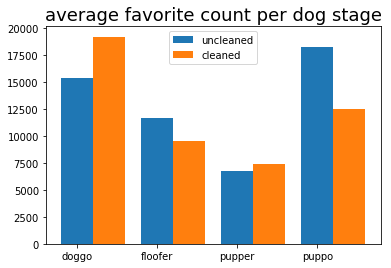

In [103]:
x= np.arange(4)
x2= np.arange(4)+0.4
plt.bar(x, fav_uncleaned['fav_average'], width= 0.4)
plt.bar(x2, fav_cleaned['fav_average'], width= 0.4)
plt.xticks(x, fav_cleaned.index)
plt.title('average favorite count per dog stage', fontsize=18)
plt.legend(['uncleaned', 'cleaned']);

Insight 2: before cleaning puppo's had the highest average number of favorite counts, but after cleaning that appears to be doggo's.
Combining this insight with insight 1, shows that the highest number of tweets are about puppers, but these tweets have the lowest average favorite counts.

### Insight 3: 

In [120]:
image_predictions.p1.value_counts().nlargest(10)

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
chow                   44
Samoyed                43
toy_poodle             39
Pomeranian             38
malamute               30
Name: p1, dtype: int64

In [119]:
image_predictions_clean.p1_dogtype.value_counts().nlargest(20)

golden_retriever             13
Pembroke                      6
Labrador_retriever            6
Pomeranian                    6
pug                           5
German_shepherd               5
Chihuahua                     4
Eskimo_dog                    4
Border_collie                 4
boxer                         3
porcupine                     3
toy_poodle                    3
chow                          3
cocker_spaniel                3
miniature_pinscher            3
Lakeland_terrier              3
French_bulldog                3
Staffordshire_bullterrier     3
Siberian_husky                3
Cardigan                      2
Name: p1_dogtype, dtype: int64

Insight 3: After cleaning list with most often predicted dog types from the images with a neural network changed. The top-6 (Golden Retriever, Labrador Retriever, Pembroke, Chihuahua, Pug and Chow) still appeared in the top-15 after cleaning, but the top-7 to top-10 didn't appear in the top-20 after cleaning.